In [12]:
import numpy as np
import gym
import d4rl

# Load the dataset
env_name = "hopper-medium-replay-v2"

env= gym.make(env_name)  # Example environment
dataset = env.get_dataset()

rewards = dataset['rewards']
timeouts = dataset['timeouts']
terminal_rewards = []

# Calculate rewards per trajectory
trajectory_reward = 0
for reward, timeout in zip(rewards, timeouts):
    trajectory_reward += reward
    if timeout:
        terminal_rewards.append(trajectory_reward)
        trajectory_reward = 0

# Handle the last trajectory if it doesn't end with a timeout
if not timeouts[-1]:
    terminal_rewards.append(trajectory_reward)




/home/zhenpeng/anaconda3/envs/dt/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|██████████| 11/11 [00:00<00:00, 24.41it/s]


In [3]:
import yaml
import wandb
import torch
import gym
from models.random import RandomModel
from data.dataset import D4RLDataset  
from data.target import TargetProcessor
from evaluating.eval import evaluate_model 

def load_config(config_path="configs/config.yaml"):
    with open(config_path, "r") as file:
        return yaml.safe_load(file)

config = load_config()

# Initialize dataset
dataset = D4RLDataset(config)
dataset.load_data()
dataset.print_trajectory_info()
dataset.print_example_datapoints()

/home/zhenpeng/anaconda3/envs/dt/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|██████████| 21/21 [00:01<00:00, 13.88it/s]


Number of trajectories in the dataset: 1000
Total number of samples (data points): 1000000
Average trajectory length: 1000.00
Total rewards accumulated across all trajectories: 10656424.0
Average reward per sample: 10.66
Minimum reward in the dataset: -3.0135135650634766
Maximum reward in the dataset: 13.854623794555664
Example datapoints (showing up to 5):

Datapoint 1:
State: [ 0.08965677 -0.03622183 -0.07804107  0.03157476 -0.01444563 -0.0344548
 -0.09393518  0.03097933  0.17581269  0.03090105 -0.02374828  0.00337915
 -0.14765297  0.06374035 -0.17055729  0.2456032  -0.11097556]
Action: [ 0.78721416  0.8764658  -0.40471458 -0.8212363  -0.47737995 -0.89712983]
Reward: -0.08235575258731842
Next State: [ 0.06860621 -0.0630245   0.12627374  0.23139715 -0.20740157 -0.2364932
 -0.04944296 -0.19534306  0.26393744 -0.7556525  -0.6779843   6.27525
  5.495971   -4.090577   -5.834749    0.29682204 -6.3176913 ]

Datapoint 2:
State: [ 0.06860621 -0.0630245   0.12627374  0.23139715 -0.20740157 -0.

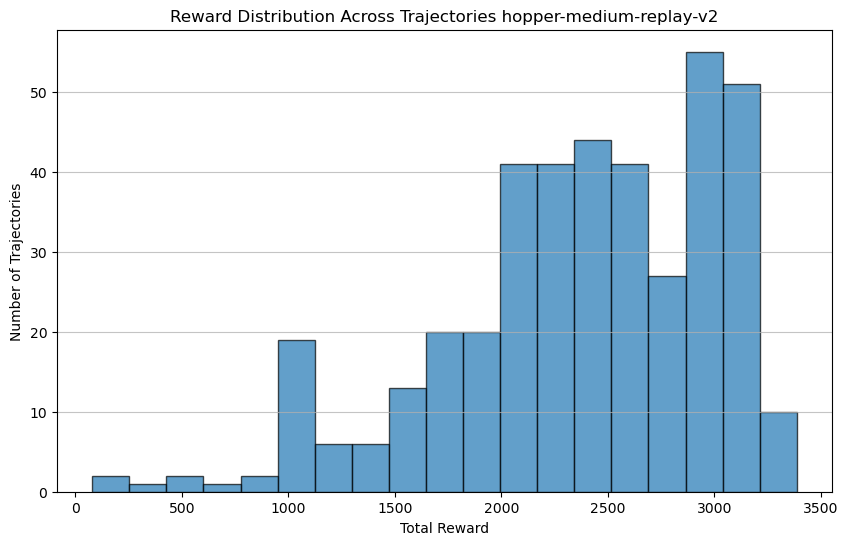

In [13]:
import matplotlib.pyplot as plt

# Determine bin edges for histogram
min_reward = min(terminal_rewards)
max_reward = max(terminal_rewards)
bins = np.linspace(min_reward, max_reward, num=20)  # Adjust the number of bins as needed

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(terminal_rewards, bins=bins, alpha=0.7, edgecolor='black')

title = f"Reward Distribution Across Trajectories {env_name}"
plt.title(title)
plt.xlabel('Total Reward')
plt.ylabel('Number of Trajectories')
plt.grid(axis='y', alpha=0.75)

plt.show()


In [35]:
import yaml
import wandb
from data.dataset import D4RLDataset  
from data.target import TargetProcessor

def load_config(config_path="configs/config.yaml"):
    with open(config_path, "r") as file:
        return yaml.safe_load(file)

config = load_config()

env_name = "hopper-medium-replay-v2"

env= gym.make(env_name)  # Example environment
dataset = env.get_dataset()


# Instantiate the TrajectoryProcessor with the mock dataset and configuration
trajectory_processor = TargetProcessor(dataset, config)

# Generate target sequences
target_sequences = trajectory_processor.generate_target_sequences()

# Displaying some basic information about the generated sequences
print(f"Number of target sequences generated: {len(target_sequences)}")
for key, seq in list(target_sequences.items())[:]:  # Display the first 5 sequences
    print(f"{key}: Sequence length = {len(seq)}")
    print(seq)
    break


load datafile: 100%|██████████| 11/11 [00:00<00:00, 17.13it/s]


Number of target sequences generated: 41
trajectory_0: Sequence length = 200
[array([ 8.8211077e-01, -5.6868095e-02, -1.2118294e+00, -5.7485080e-01,
       -2.1612272e-03,  3.4278455e+00, -1.6542528e+00, -4.7904658e-01,
        3.5811973e+00, -9.8717241e+00, -1.0000000e+01], dtype=float32), array([ 0.19601828, -0.42153245, -0.9920884 ], dtype=float32), array([  0.8686925 ,  -0.06093611,  -1.1816199 ,  -0.65510356,
        -0.1507008 ,   3.2764637 ,  -1.7015035 ,  -0.5349711 ,
         3.9735987 , -10.        , -10.        ], dtype=float32), array([ 0.12515806,  0.62724495, -0.98991764], dtype=float32), array([  0.85472035,  -0.06361832,  -1.1492846 ,  -0.7322908 ,
        -0.31024122,   3.2873938 ,  -1.7910094 ,  -0.13691576,
         4.109672  ,  -9.113935  , -10.        ], dtype=float32), array([ 0.46810976,  0.46867126, -0.9884448 ], dtype=float32), array([  0.84015405,  -0.06177816,  -1.1138402 ,  -0.8019621 ,
        -0.48083228,   3.324339  ,  -1.8507146 ,   0.5982046 ,
         

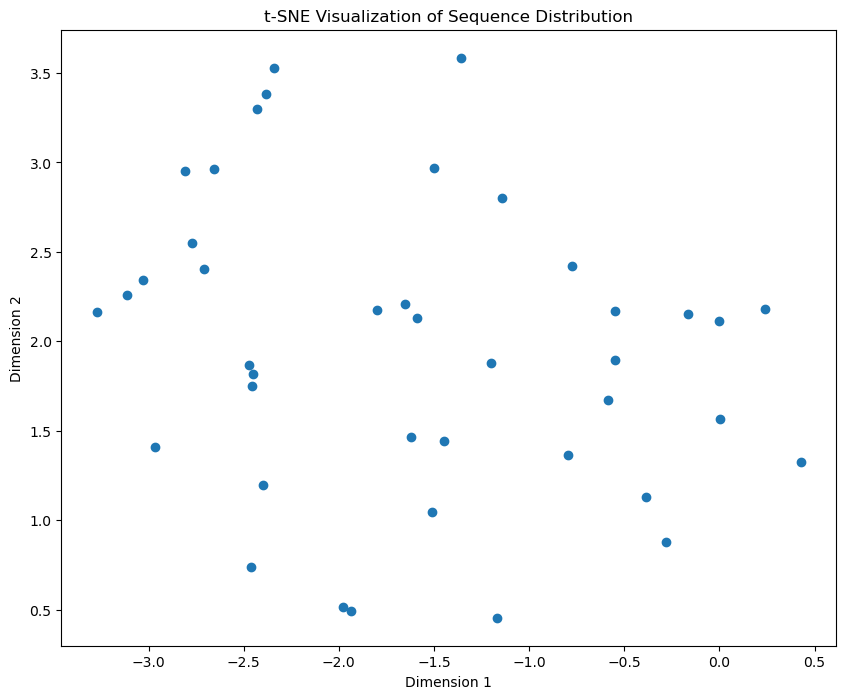

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assuming target_sequences is defined somewhere as per your actual data

flattened_sequences = {}
# Flatten the sequences
for key, seq in target_sequences.items():
    numeric_parts = [part for part in seq if isinstance(part, np.ndarray)]
    flattened_sequence = np.concatenate(numeric_parts)
    flattened_sequences[key] = flattened_sequence

# Convert flattened sequences to a numpy array
preprocessed_sequences = np.array(list(flattened_sequences.values()))

# Apply t-SNE to reduce the dimensionality to 2
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(preprocessed_sequences)

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.title('t-SNE Visualization of Sequence Distribution')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


In [37]:
import yaml
import wandb
from data.dataset import D4RLDataset  
from data.target import TargetProcessor

def load_config(config_path="configs/config.yaml"):
    with open(config_path, "r") as file:
        return yaml.safe_load(file)

config = load_config()

env_name = "hopper-medium-replay-v2"

env= gym.make(env_name)  # Example environment
dataset = env.get_dataset()


# Instantiate the TrajectoryProcessor with the mock dataset and configuration
trajectory_processor = TargetProcessor(dataset, config)

# Generate target sequences
target_sequences2 = trajectory_processor.generate_target_sequences()

# Displaying some basic information about the generated sequences
print(f"Number of target sequences generated: {len(target_sequences2)}")
for key, seq in list(target_sequences2.items())[:]:  # Display the first 5 sequences
    print(f"{key}: Sequence length = {len(seq)}")
    print(seq)
    break


/home/zhenpeng/anaconda3/envs/dt/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|██████████| 11/11 [00:00<00:00, 19.04it/s]


Number of target sequences generated: 361
trajectory_0: Sequence length = 200
[array([ 1.2400005e+00,  1.1673706e-02,  2.7239088e-03,  7.3844660e-03,
        1.2673794e-01,  1.0630865e-01, -5.1265180e-01,  1.2825891e-01,
        2.6780615e-02, -7.2930425e-02,  5.9008150e+00], dtype=float32), array([0.9440028, 0.9416874, 0.9646133], dtype=float32), array([ 1.2354748e+00,  1.2713994e-02,  2.9121672e-03,  6.7273765e-03,
        1.7935736e-01,  1.2637052e-01, -6.1863834e-01,  1.3222931e-01,
        2.0494509e-02, -8.7239757e-02,  7.2520666e+00], dtype=float32), array([0.98526585, 0.9515508 , 0.94097114], dtype=float32), array([ 1.2312821e+00,  1.5044116e-02,  3.0462681e-03,  5.9822840e-03,
        2.4015896e-01,  3.2933131e-01, -3.5411221e-01,  5.1346254e-01,
        1.2530722e-02, -9.8502785e-02,  7.7973790e+00], dtype=float32), array([0.97566634, 0.97721934, 0.981042  ], dtype=float32), array([ 1.2298145e+00,  2.0652015e-02,  3.1229728e-03,  5.2130665e-03,
        3.0444232e-01,  5.43978

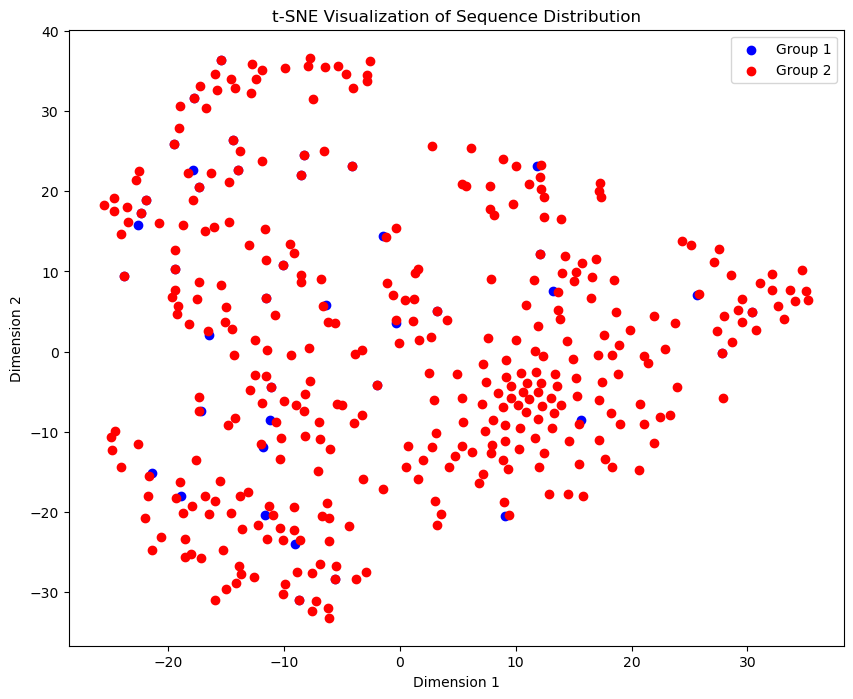

In [38]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Flatten function for sequences
def flatten_sequences(target_sequences):
    flattened_sequences = {}
    for key, seq in target_sequences.items():
        numeric_parts = [part for part in seq if isinstance(part, np.ndarray)]
        flattened_sequence = np.concatenate(numeric_parts)
        flattened_sequences[key] = flattened_sequence
    return np.array(list(flattened_sequences.values()))

# Flatten both sets of sequences
preprocessed_sequences_1 = flatten_sequences(target_sequences)
preprocessed_sequences_2 = flatten_sequences(target_sequences2)

# Combine into one array
combined_sequences = np.vstack((preprocessed_sequences_1, preprocessed_sequences_2))

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=6)
tsne_results = tsne.fit_transform(combined_sequences)

# Plot the results
plt.figure(figsize=(10, 8))
# Sequences from the first group
plt.scatter(tsne_results[:len(preprocessed_sequences_1), 0], tsne_results[:len(preprocessed_sequences_1), 1], color='blue', label='Group 1')
# Sequences from the second group
plt.scatter(tsne_results[len(preprocessed_sequences_1):, 0], tsne_results[len(preprocessed_sequences_1):, 1], color='red', label='Group 2')
plt.title('t-SNE Visualization of Sequence Distribution')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


In [ ]:
####test the basic diffusion model 
from models.diffusion_model import UnconditionalDiffusionModel
input_dim = 784  # Example for a flattened 28x28 image
model_dim = 512
n_timesteps = 1000
model = UnconditionalDiffusionModel(input_dim=input_dim, model_dim=model_dim, n_timesteps=n_timesteps)


In [ ]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torch 
# Load dataset
dataset = MNIST(root='./MinistData', train=True, transform=ToTensor(), download=True)
# Convert dataset to a tensor and flatten the images
data = torch.stack([d[0] for d in dataset]).view(-1, 28*28)
data = data[:100]


In [ ]:
print(data.shape)

In [ ]:
epochs = 10
for epoch in range(epochs):
    epoch_loss = 0
    for x_start in data:
        x_start = x_start.unsqueeze(0)  # Add batch dimension
        print(x_start.shape)
        loss = model.train_step(x_start)
        epoch_loss += loss
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(data)}")
